# Описание проекта


## Постановка задачи
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки. Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

## Описание последовательности выполнения проекта

### Часть 1 - Приоритизация гипотез

Загрузка файлов, их изучение и подготовка к дальнейшему анализу.

Применение фреймворков ICE и RICE для приоритизации гипотез.

Анализ того, какие есть различия в приоритизации между двумя фреймворкам.

### Часть 2 - Анализ A/B-теста

Загрузка файлов, их изучение и подготовка к дальнейшему анализу.

Построение графиков по основным метрикам (кумулятивная выручка, кумулятивный средний чек, кумулятивная конверсия по группам, относительное изменение кумулятивного среднего чека и конверсии группы В к группе А, стоимость заказа)

Расчёт 95 и 99 перцентилей количества заказов на пользователя, стоимости заказов. Выбор границ для определения аномальных пользователей, а затем их фильтрация.

Расчёт статистической значимости различий в конверсии и среднем чеке между группами по "сырым", а затем "очищенным" данным.

Принятие решения по результатам теста. Возможные исходы - Остановка теста и фиксация победы одной из групп, Остановка теста и фиксация отсутствия различий между группами, Продолжение теста.

### Описание данных

#### Данные для первой части

#### Таблица hypothesis

Hypothesis — краткое описание гипотезы;

Reach — охват пользователей по 10-балльной шкале;

Impact — влияние на пользователей по 10-балльной шкале;

Confidence — уверенность в гипотезе по 10-балльной шкале;

Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

#### Данные для второй части

#### Таблица orders

transactionId — идентификатор заказа;

visitorId — идентификатор пользователя, совершившего заказ;

date — дата, когда был совершён заказ;

revenue — выручка заказа;

group — группа A/B-теста, в которую попал заказ.

#### Таблица visitors

date — дата;

group — группа A/B-теста;

visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Шаг 1. Загрузка данных и подготовка их к анализу

In [1]:
# Импортируем  библиотеки
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import seaborn as sns
import datetime as dt
import scipy.stats as stats

# отключение уведомлений об ошибке при замене исходного набора данных
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [2]:
# загружаем файлы в переменные и выводим на экран
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

#### 1.1. Предобработка таблицы hypothesis

In [3]:
pd.options.display.max_colwidth = 130
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


#### Hypothesis — краткое описание гипотезы;

Reach — охват пользователей по 10-балльной шкале;

Impact — влияние на пользователей по 10-балльной шкале;

Confidence — уверенность в гипотезе по 10-балльной шкале;

Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


#### Данные полные и не требуют дополнительных корректировок

#### 1.2. Предобработка таблицы orders

In [5]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


#### transactionId — идентификатор заказа;

visitorId — идентификатор пользователя, совершившего заказ;

date — дата, когда был совершён заказ;

revenue — выручка заказа;

group — группа A/B-теста, в которую попал заказ.

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
# Поменяем тип столбца "date" на datetime
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [8]:
# Приведем названия столбцов к "змеиному" регистру
orders = orders.rename(columns={'transactionId':'order_id', 'visitorId':'visitor_id'})

In [9]:
# Проверим таблицу на наличие дубликатов
orders.duplicated().sum()

0

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_id    1197 non-null   int64         
 1   visitor_id  1197 non-null   int64         
 2   date        1197 non-null   datetime64[ns]
 3   revenue     1197 non-null   int64         
 4   group       1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [11]:
orders['date'].describe(datetime_is_numeric=True)

count                             1197
mean     2019-08-15 13:06:46.015037696
min                2019-08-01 00:00:00
25%                2019-08-08 00:00:00
50%                2019-08-15 00:00:00
75%                2019-08-23 00:00:00
max                2019-08-31 00:00:00
Name: date, dtype: object

In [12]:
orders["group"].value_counts()

B    640
A    557
Name: group, dtype: int64

#### У нас имеется две группы, группа А - 557 человек, группа В - 640. Это значит, что сравнительные данные по группам могут незначительно исказится из-за неравномерного распределения пользователей по группам

In [13]:
orders[['visitor_id', 'group']].duplicated().sum()

108

#### В исследовании присутствуют 108 клиентов, которые в разное время относились к разным группам теста

#### Таблица готова к работе

#### 1.3 Предобработка таблицы visitors

In [14]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


#### date — дата;

group — группа A/B-теста;

visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [15]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [16]:
# Поменяем тип столбца "date" на datetime
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [17]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [18]:
# Проверим таблицу на наличие дубликатов
visitors.duplicated().sum()

0

In [19]:
visitors["date"].describe(datetime_is_numeric=True)

count                     62
mean     2019-08-16 00:00:00
min      2019-08-01 00:00:00
25%      2019-08-08 06:00:00
50%      2019-08-16 00:00:00
75%      2019-08-23 18:00:00
max      2019-08-31 00:00:00
Name: date, dtype: object

In [20]:
visitors["group"].value_counts()

B    31
A    31
Name: group, dtype: int64

#### Число групп совпадает с количеством дней в августе

In [21]:
visitors.groupby(['date','group'])['visitors'].sum()

date        group
2019-08-01  A        719
            B        713
2019-08-02  A        619
            B        581
2019-08-03  A        507
                    ... 
2019-08-29  B        531
2019-08-30  A        490
            B        490
2019-08-31  A        699
            B        718
Name: visitors, Length: 62, dtype: int64

In [22]:
visitorsA = visitors[visitors['group']=='A'][['date','group', 'visitors']]
visitorsB = visitors[visitors['group']=='B'][['date','group', 'visitors']]

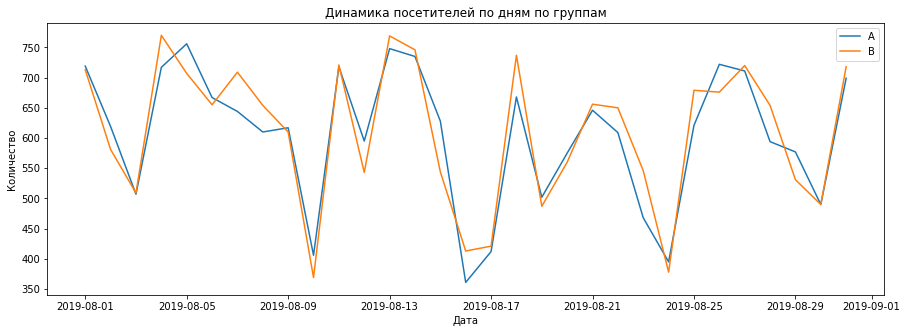

In [23]:
plt.figure(figsize=(15,5))
# Строим график выручки группы А
plt.plot(visitorsA['date'], visitorsA['visitors'], label='A')
# Строим график выручки группы B
plt.plot(visitorsB['date'], visitorsB['visitors'], label='B')
plt.title('Динамика посетителей по дням по группам')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.legend(); 

#### Видим динамику посетителей по дням по группам - в основном количество клиентов группы В превышает количество клиентов группы А

#### Таблица готова к работе

### Вывод: мы подготовили таблицы к работе. В таблице с гипотезами нам ничего не пришлось менять. В таблицах с заказами и клиентами изменили тип столбца с датами, привели 2 столбца таблицы с заказами к "змеиному" регистру. Период тестирования гипотез в таблицах совпадает - с 01.08.19 по 31.08.19

### Шаг 2. Приоритизация гипотез.

Задача

Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

In [24]:
display(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [25]:
hypothesis['ICE'] = round((hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts'],1)
hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


In [26]:
hypothesis['RICE'] = round((hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts'],1)
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


### Вывод
#### Использование фреймворка ICE выявило  3 наиболее перспективных гипотезы, у которых индексы 8 (16,2 балла), 0 (13,3) и 7 (11,2).  По фреймворку RICE 3 наиболее перспективных гипотезы - с индексами 7 (112 балла), 2 (56) и 0 (40). Видим, что из 3-х перспективных гипотезы, 2 совпадают в обоих фреймворках - "Добавить форму подписки на все основные страницы" (7 индекс) и "Добавить два новых канала привлечения трафика" (0 индекс).

#### При использовании фреймворка RICE приоретизация изменилась за счет введения в расчет дополнительного параметра по охвату гипотезой клиентов.  Т.е., при прочих равных условиях приоритетней стали гипотезы, которые затронут большее количество потенциальных клиентов.

### Шаг 3. Анализ A/B-теста

#### 3.1. Построим график кумулятивной выручки по группам

In [27]:
# создадим таблицу cumulativeData куммулятивных данных по обеим таблицам
datesGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]. \
                                     agg({'date' : 'max', 
                                          'group' : 'max', 
                                          'order_id' : pd.Series.nunique, 
                                          'visitor_id' : pd.Series.nunique, 
                                          'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]. \
                                       agg({'date' : 'max', 
                                            'group' : 'max', 
                                            'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [28]:
cumulativeData["date"].describe()

count                      62
unique                     31
top       2019-08-27 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

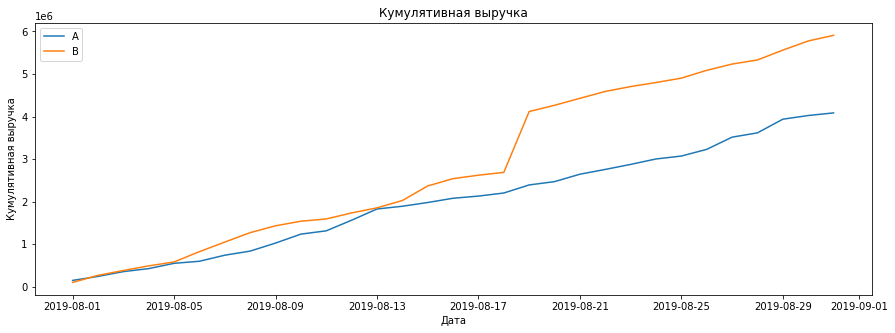

In [29]:
# построим графики кумулятивной выручки по дням по группам
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,5))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.legend(); 

#### Как видно из приведенного графика в начале месяца до 5 числа включительно выручка в группах не отличалась. С 5 по примерно 13 августа выручка группы В начала расти более высокими темпами. 13 числа выручки по группам сравнялись, а затем выручка группы В стабильно росла лучше, чем в группе А. 

Обращает на себя внимание дата 19.08 - резкий рост выручки может свидетельствовать об аномалиях, которые могут искажать результаты A/B-теста.

In [30]:
# проверим выручку за этот день
print('Медианное значение одного заказа 19 августа =',orders.query('date == "2019-08-19"')['revenue'].median())
orders.query('date == "2019-08-19"').sort_values(by='revenue', ascending=False).head(10)

Медианное значение одного заказа 19 августа = 2630.0


,order_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
530,3970235543,2912540959,2019-08-19,43990,A
527,1570513684,2837914161,2019-08-19,33405,B
421,3765974140,1357170471,2019-08-19,31680,A
461,2683113224,154576532,2019-08-19,26550,B
525,3031564664,393266494,2019-08-19,21550,A
368,3268879337,2536252163,2019-08-19,20026,B
366,2037051350,1957949546,2019-08-19,16770,A
463,4170537404,290022471,2019-08-19,16480,B
531,4016435970,4017075195,2019-08-19,13390,A


In [31]:
# посмотрим кол-во заказов за ближайшие 4 дня
cumulativeRevenueB.query(' "2019-08-17" <= date <= "2019-08-21" ')

,date,revenue,orders
33,2019-08-17,2620790,373
35,2019-08-18,2686621,382
37,2019-08-19,4116541,403
39,2019-08-20,4263815,423
41,2019-08-21,4426892,437


#### Как можно убедиться в группе В 19.08 один клиент (id 1920142716) закупился  на 1,3 млн. ден.ед. при медианной выручке 1-го заказа за этот день - 2,6 тыс. ден. ед. По количеству заказов всплесков не наблюдается. Таким образом, поскольку этот заказ один, то его в принципе можно считать выбросом и при дальнейшем анализе это надо учитывать.

#### 3.2. Построим график кумулятивного среднего чека по группам

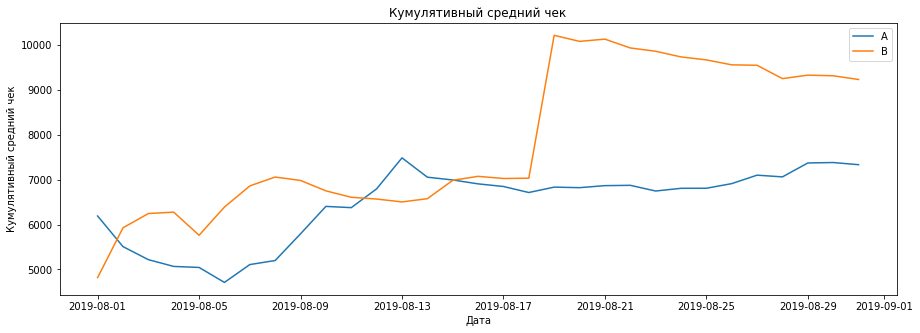

In [32]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

# Строим графики среднего чека по группам
plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Кумулятивный средний чек')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.legend() ;

#### Наблюдаем некую схожесть с предыдущим графиком за периоды с 05.08 по 13.08 и с 15.08 и до конца месяца - средний чек по группе В выше. Также видим всплеск 19.08 по чеку 590470918 в группе В.  И с этой даты средний чек группы В постепенно снижается, а группы А - повышается, хотя на конец месяца между чеками разрыв составляет ~ 2000 ден. ед.

#### 3.3. Построим график  относительного изменения кумулятивного среднего чека группы B к группе A

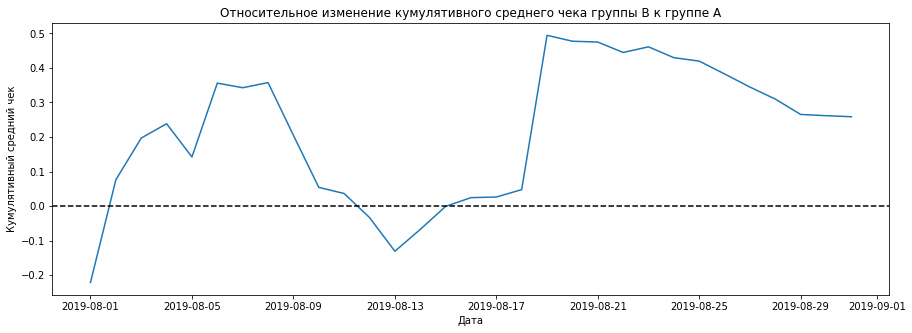

In [33]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeRevenue.columns = [
    'date',
    'revenueA',
    'ordersA',
    'revenueB',
    'ordersB',
]
# cтроим отношение средних чеков
plt.figure(figsize=(15,5))
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--'); 

#### В нескольких точках график различия между средними чеками резко «скачет» (в т.ч. и 19.08.19). Видимо в эти периоды происходили аномальные заказы 

#### 3.4. Построим график кумулятивного среднего количества заказов на посетителя по группам

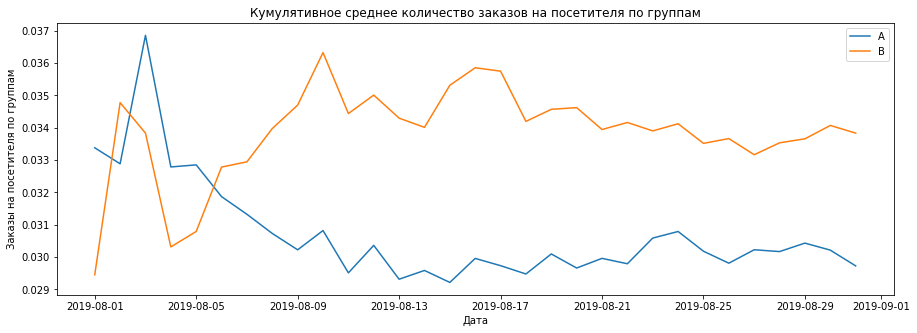

In [34]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Заказы на посетителя по группам')
plt.legend();

#### Примерно до 06.08.19 конверсия по группе А была повыше. Но затем практически симметрично конверсия группы В вырвалась вперёд, а конверсия группы А просела.

#### 3.5. Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

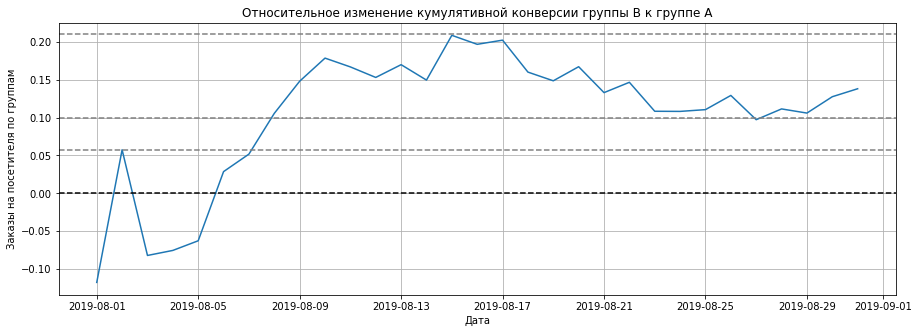

In [35]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], \
                                                    left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Заказы на посетителя по группам')

plt.axhline(y=0, color='black', linestyle='--') 
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axhline(y=0.21, color='grey', linestyle='--')
plt.axhline(y=0.057, color='grey', linestyle='--');

#### Примерно до 06.08 кумулятивная конверсия группы В то выше, то ниже группы А. Далее конверсия группы В резко двинулась вверх и на пике разница достигала 21%, а в конце теста разница составляет ~14% и продолжает расти

#### 3.6. Построим точечный график количества заказов по пользователям

      visitor_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


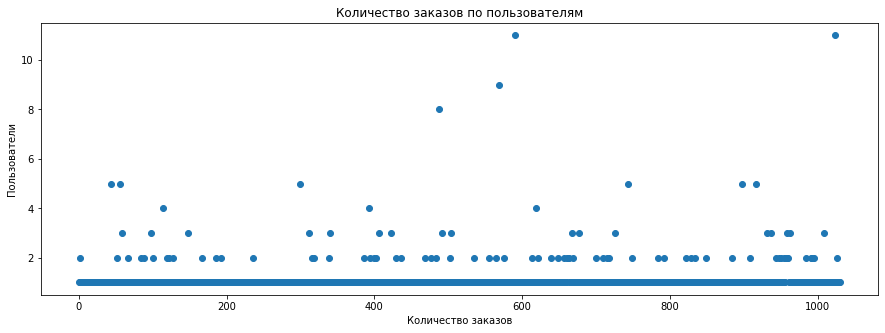

In [36]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'order_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))
# серия из чисел от 0 до количества наблюдений в ordersByUsers
plt.figure(figsize=(15,5))
plt.title('Количество заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Пользователи')
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']);

#### Видим, что заказов больше 2-х немного. Поэтому дальше проверяем, где начинаются аномалии

#### 3.7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [37]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 2. 4.]


In [38]:
# детализируем 
print(np.percentile(ordersByUsers['orders'], [96, 97, 98, 99])) 

[2. 2. 3. 4.]


#### не более 2% клиентов совершали 3 покупки, и не более 1% - 4 покупки. Приймем, что 3 и более покупок за аномалии

#### 3.8. Построим точечный график стоимостей заказов

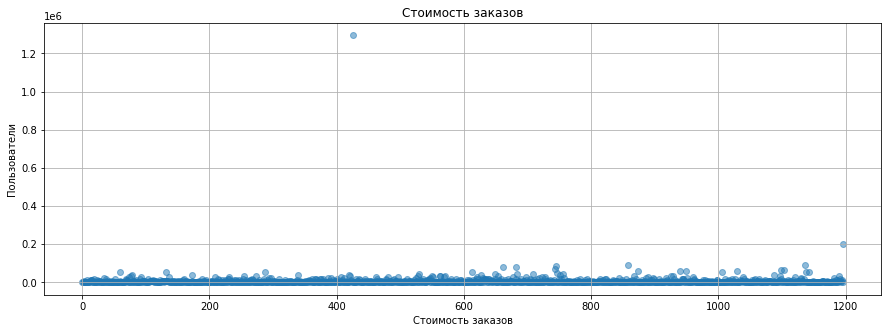

In [39]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('Стоимость заказов')
plt.xlabel('Стоимость заказов')
plt.ylabel('Пользователи')
plt.scatter(x_values, orders['revenue'], alpha=0.5);

#### На графике выделяется 1 абсолютно аномально-элитный заказ на 1,3 млн. и 1 заказ на 200,0 тыс. ден.ед., которые являются выбросами

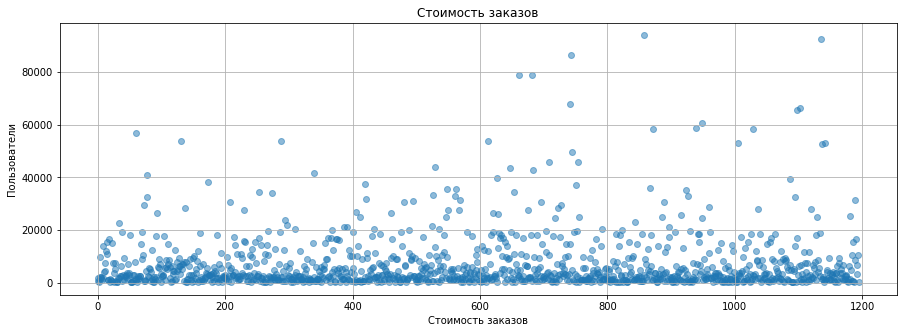

In [40]:
# укрупним график и избавимся от выбросов
norm_orders = orders[orders['revenue']<=199000]['revenue']
x_values = pd.Series(range(0, len(norm_orders)))
plt.figure(figsize=(15,5))
plt.title('Стоимость заказов')
plt.xlabel('Стоимость заказов')
plt.ylabel('Пользователи')
plt.grid()
plt.scatter(x_values, norm_orders, alpha=0.5);

#### Остальные заказы не превышают 100,0 тыс. ден. ед.

#### 3.9 Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [41]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.  28000.  58233.2]


#### Не более, чем у 5% чек больше 28000 ден.ед. и не более чем у 1% - больше 58233,2 ден. ед. Превышение 58233,2 и приймем за аномалию.

#### 3.10. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

#### Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.

In [42]:
# расчет количества пользователей в выбранную дату в группах
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


ordersADaily = orders[orders['group']=='A'][['date', 'order_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'order_id' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'order_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'order_id' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

# Посчитаем статистическую значимость различия в среднем количестве заказов между группами
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'order_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'order_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')] 

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'order_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'order_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print("p-value = {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))
 

p-value = 0.01679
Относительный показатель 'B' и 'A' = 0.138


#### Первое число — p-value = 0.01679 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем.  

Таким образом, анализ "сырых данных" показал, что в среднем числе заказов между группами есть статистически значимые различия и нам их нужно найти.

Относительный прирост группы B равен 13.8%.

#### 3.11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

#### За нулевую гипотезу возьмём что: "статистически значимых различий в средних чеках между группами нет"; тогда альтернативная гипотеза будет гласить - статистически значимые различия есть.

In [43]:
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value = 0.729
Относительный показатель 'B' и 'A' = 0.259


#### P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.

Относительное различие среднего чека между сегментами достаточно высокое - 25,9%

#### 3.12. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

#### Как ранее мы установили, аномалиями являются более 2-х покупок и заказы на сумму более 58233 ден. ед. 

In [44]:
# посчитаем аномальных пользователей
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'], ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitor_id']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print("Всего аномальных пользователей =", len(abnormalUsers)) 

1099    148427295
18      199603092
23      237748145
37      249864742
68      457167155
Name: visitor_id, dtype: int64
Всего аномальных пользователей = 31


#### Сформулируем гипотезы. Нулевая: различий в среднем количестве "очищенных" заказов между группами нет. Альтернативная: различия в среднем между группами есть.

In [45]:
# Создадим переменные, в которых сохраним очищенные данные о заказах — не включая аномальных пользователей
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

print('p-value = {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value = 0.01007
Относительный показатель 'B' и 'A' = 0.174


#### Как и в случае с "сырыми" данными нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, мы отвергаем.
Таким образом, анализ "очищенных" данных также показал, что в среднем числе заказов между группами есть статистически значимые различия.

Относительный прирост группы B улучшился и равен 17.4%.

#### 3.13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

#### За нулевую гипотезу приймем: "статистически значимых различий в средних чеках между группами нет"; тогда альтернативная гипотеза - статистически значимые различия есть

In [46]:
print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительный показатель 'B' и 'A' = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 


p-value = 0.798
Относительный показатель 'B' и 'A' = -0.020


#### P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия,тоже нет (как и с "Сырыми" данными).

Видим, что P-value без аномалий увеличился - с 72,9% до 79,8%.

При этом разница по среднему чеку кардинально изменилась - средний чек группы B оказался незначительно (на 2%) ниже среднего чека группы A (сыграли свою роль 2 аномальных заказа - на 1,3 млн. и на 200,0 тыс. ден.ед.).

#### 3.13.1. Для полноты картины создадим очищенные от аномальных значений датафреймы и построим по ним графики 

In [47]:
orders_filtered = orders[np.logical_not(orders['visitor_id'].isin(abnormalUsers))]
datesgroupes = orders_filtered[['date', 'group']].drop_duplicates()

orders_agg_filtered = datesgroupes.apply(
    lambda x: orders_filtered[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date':'max', 'group':'max', 'order_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'}),
     axis=1)\
    .sort_values(by=['date', 'group'])

visitors_agg_filtered = datesgroupes.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] ==x['group'])]
    .agg({'date':'max', 'group':'max', 'visitors':'sum'}),
     axis=1)\
    .sort_values(by=['date', 'group'])

In [48]:
data_cummulative_filtered = orders_agg_filtered.merge(visitors_agg_filtered, on = ['date', 'group'])
data_cummulative_filtered.columns = ['date','group','orders','buyers','revenue','visitors']

#### а) График кумулятивной выручки по группам

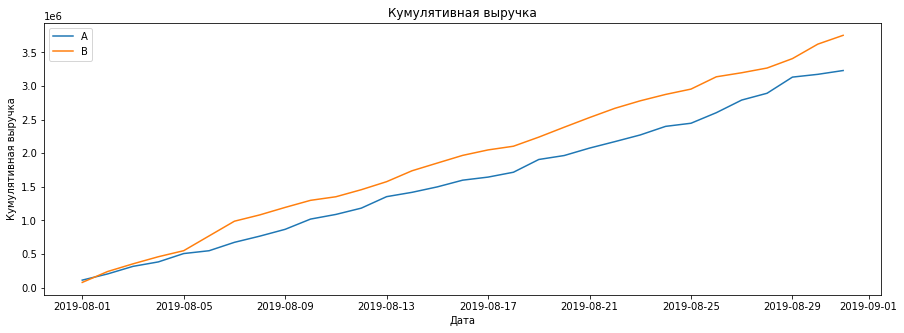

In [49]:
cumulative_group_A_filtered = (
    data_cummulative_filtered[data_cummulative_filtered['group'] == 'A'][['date', 'revenue', 'orders']])
    
cumulative_group_B_filtered = (
    data_cummulative_filtered[data_cummulative_filtered['group'] == 'B'][['date', 'revenue', 'orders']])

plt.figure(figsize=(15,5))
# Строим график 'очищенной' выручки группы А
plt.plot(cumulative_group_A_filtered['date'], cumulative_group_A_filtered['revenue'], label='A')

# Строим график 'очищенной' выручки группы B
plt.plot(cumulative_group_B_filtered['date'], cumulative_group_B_filtered['revenue'], label='B')
plt.title('Кумулятивная выручка')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.legend(); 

#### На графике без аномалий видим, что доходы по группе В так и остались выше, но разница существенно снизилась

#### б) График кумулятивного среднего чека по группам

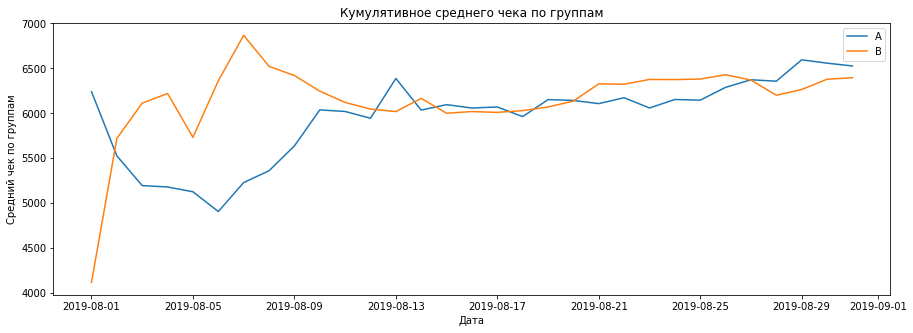

In [50]:
cumulative_group_A_filtered = data_cummulative_filtered[data_cummulative_filtered['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulative_group_B_filtered = data_cummulative_filtered[data_cummulative_filtered['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

# Строим графики среднего чека по группам
plt.figure(figsize=(15,5))
plt.plot(cumulative_group_A_filtered['date'], cumulative_group_A_filtered['revenue']/cumulative_group_A_filtered['orders'], label='A')
plt.plot(cumulative_group_B_filtered['date'], cumulative_group_B_filtered['revenue']/cumulative_group_B_filtered['orders'], label='B')
plt.title('Кумулятивное среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек по группам')
plt.legend(); 

#### На графике без аномалий видим, что размеры средних чеков по группам постоянно меняются местами

#### в) График кумулятивного среднего количества заказов на посетителя по группам

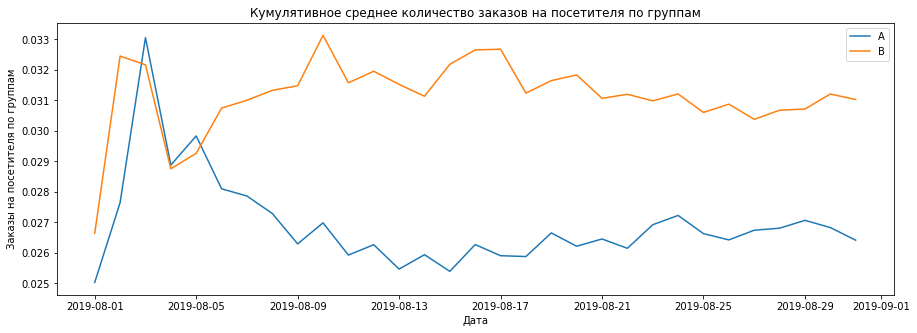

In [51]:
# считаем кумулятивную конверсию
data_cummulative_filtered['conversion'] = data_cummulative_filtered['orders']/data_cummulative_filtered['visitors']

# отделяем данные по группе A
cumulative_group_A_filtered = data_cummulative_filtered[data_cummulative_filtered['group']=='A']

# отделяем данные по группе B
cumulative_group_B_filtered = data_cummulative_filtered[data_cummulative_filtered['group']=='B']

# строим графики
plt.figure(figsize=(15,5))
plt.plot(cumulative_group_A_filtered['date'], cumulative_group_A_filtered['conversion'], label='A')
plt.plot(cumulative_group_B_filtered['date'], cumulative_group_B_filtered['conversion'], label='B')
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Заказы на посетителя по группам')
plt.legend();

#### Конверсия также немного сгладилась, но у группы В она лучше

#### 3.14. Принимаем решение по результатам теста 

#### На момент принятия решения мы имеем следующие данные:

- Имеем статистически значимые различия по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий;

- И по "сырым" и по "очищенным" данным различия в конверсии групп A и B есть. Относительный выигрыш группы "B" над "A" равен 17,3% по "очищенным" и ~14% по "сырым" данным.

- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. Разница по среднему чеку без учета аномалий кардинально изменилась - средний чек группы B оказался незначительно (на 2%) ниже среднего чека группы A;


### Принятие решения по результатам теста

На основе проведенного исследования можно принять решение об остановке теста и признать его успешным. Между группами наблюдается лучшая конверсия у группы В. И несмотря на то, что значимых отличий по кумулятивному среднему чеку не наблюдается, основная цель гипотез достигнута - получено увеличение выручки. 